In [2]:
import requests
from bs4 import BeautifulSoup
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# BDT packages
import xgboost as xgb
import lightgbm as lgb

In [3]:
### Set default plot parameters

# Font and fontsize
rc = {"font.family" : "serif", 
      "mathtext.fontset" : "stix"}
plt.rcParams.update(rc)
plt.rcParams["font.serif"] = ["Times New Roman"] + plt.rcParams["font.serif"]
plt.rcParams['font.size'] = 14
plt.rcParams['axes.titlesize'] = 20
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['legend.fontsize'] = 12

# Grid
plt.rcParams['grid.linestyle'] = '--'
plt.rcParams['grid.linewidth'] = 0.5
plt.rcParams['grid.color'] = 'white'
plt.rcParams['axes.grid'] = True

# Background color
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['axes.facecolor'] = 'gainsboro'
plt.rcParams['savefig.facecolor'] = 'white'

# Legend background color
plt.rcParams['legend.facecolor'] = 'white'

In [4]:
# Load the data
data = pd.read_csv("AppML_InitialProject_train.csv", sep=",")

# Slicing the data for only electrons
input_data = data[data['p_Truth_isElectron'] == 1]
energy_data = input_data['p_Truth_Energy']
input_data = input_data.drop(columns=['p_Truth_isElectron', 'p_Truth_Energy'])
variables = input_data.columns.tolist()
test_data = pd.read_csv("AppMl_InitialProject_test_classification.csv", sep=",")

from sklearn.model_selection import train_test_split
X_train, X_valid, y_train, y_valid = train_test_split(input_data, energy_data, test_size=0.2, random_state=42)


### Using SHAP values and Permutation Importance to determine the top 12 important features

In [5]:
# Training a regression model on all varaibles (LGBM)
params = {
        'objective': 'regression',
        'boosting_type': 'gbdt',
        'metric': 'rmse',
        'max_depth': -1,
        'num_leaves': 30,
        'learning_rate': 0.1,
        'min_data_in_leaf': 20,
        'n_estimators': 1000,
        'verbose': -1,
        'early_stopping_rounds': 20
}
reg_model = lgb.LGBMRegressor(**params)
model = reg_model.fit(X_train, y_train, eval_set=[(X_valid, y_valid)])


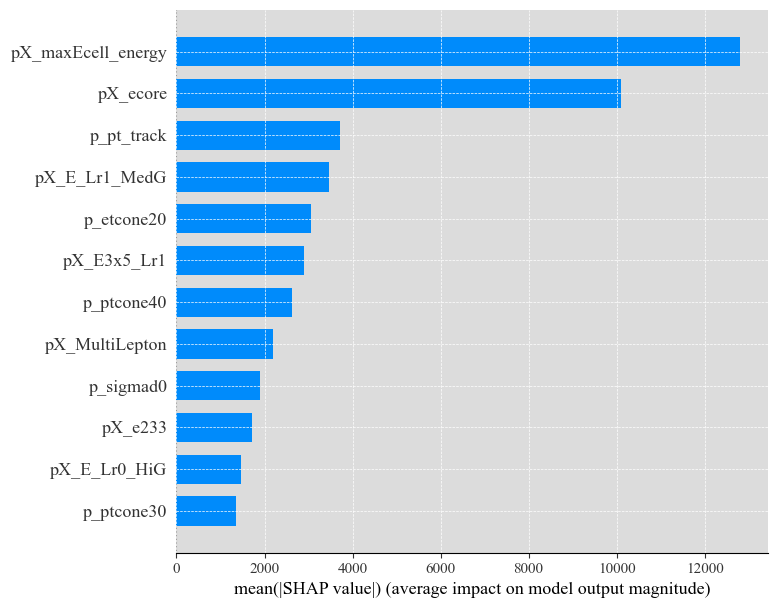

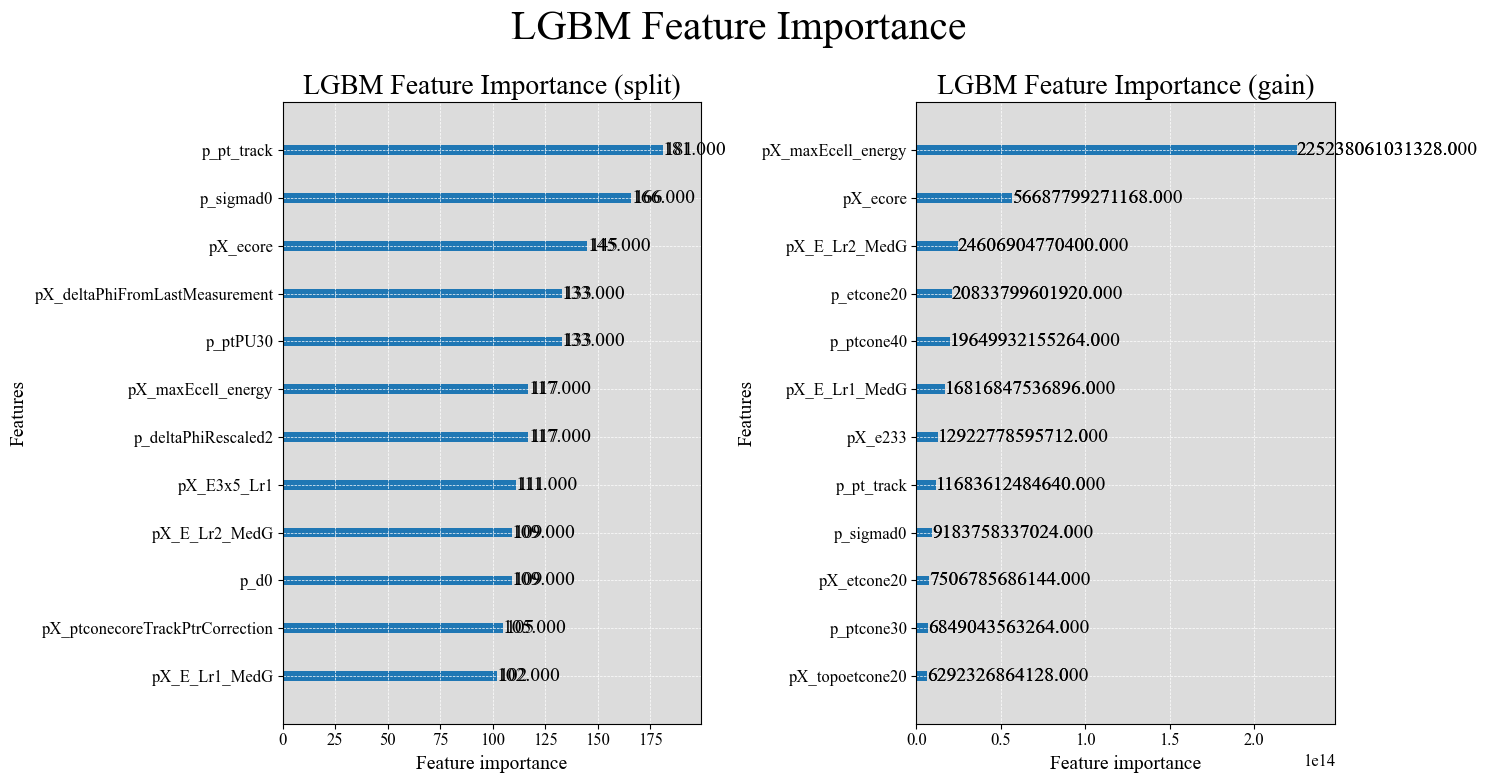

In [6]:
import shap

# SHAP values
fig = plt.figure(figsize=(15, 8))
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_valid)
shap.summary_plot(shap_values, 
                  X_valid, 
                  feature_names=variables, 
                  plot_type="bar",
                  max_display=12, 
                  color_bar=True)

# LGBM feature importance
fig, ax = plt.subplots(1,2,figsize=(15, 8))
lgb.plot_importance(model, 
                     max_num_features=12, 
                     importance_type='split', 
                     ax=ax[0], 
                     title="LGBM Feature Importance (split)",
                     precision=1)

lgb.plot_importance(model,
                     max_num_features=12, 
                     importance_type='gain', 
                     ax=ax[1], 
                     title="LGBM Feature Importance (gain)",
                     precision=1)


for axi in ax:
    for p in axi.patches:
        width = p.get_width()
        axi.text(width + 0.01,           # x-position
                p.get_y() + p.get_height() / 2,  # y-position
                f"{width:.3f}",         # rounded label
                va='center')


fig.suptitle("LGBM Feature Importance", fontsize=30)
plt.tight_layout()

# Extracting top 12 features from SHAP values
shap_importance = pd.DataFrame(list(zip(variables, np.abs(shap_values).mean(axis=0))), 
                                columns=["Feature", "SHAP_Importance"])
shap_top12 = shap_importance.sort_values(by="SHAP_Importance", ascending=False).head(12)



# Extracting top 12 features from LGBM gain plot
lbg_importance = model.booster_.feature_importance(importance_type='gain')
feature_names = model.booster_.feature_name()

lgb_importance = pd.DataFrame({
    "Feature": feature_names,
    "LGBM_Gain_importance": lbg_importance
})
lgb_top12 = lgb_importance.sort_values(by="LGBM_Gain_importance", ascending=False).head(12)

# Merging the two dataframes
importance_df = pd.merge(shap_top12, lgb_top12, on="Feature", how="outer")


In [7]:
from sklearn.inspection import permutation_importance

# Permutation importance
perm_importance = permutation_importance(model, X_valid, y_valid, n_repeats=10, random_state=42)
perm_importance_df = pd.DataFrame({
    "Feature": X_valid.columns,
    "Permutation_Importance": perm_importance.importances_mean
})



In [10]:
perm_top12 = perm_importance_df.sort_values(by="Permutation_Importance", ascending=False).head(12)
sort_variables = pd.Series(perm_top12["Feature"])
sort_variables.to_csv("handins/Regression_NielsDavidsen_LightGBMreg_VariableList.csv", index=False, header=False)


lgb_top12_features = lgb_top12["Feature"].tolist()
pd.DataFrame(lgb_top12_features).to_csv("handins/Regression_NielsDavidsen_TorchNNreg_VariableList.csv", index=False, header=False)